In [542]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [543]:
# Chargement des données
file_path = 'data/immodataParis.csv'
base_data = pd.read_csv(file_path)

data = base_data[['Arrondissement', 'Prix (€)',
       'Prix mensuel (€)', 'Pièce(s)', 'Surface (m2)']].copy()

df = pd.DataFrame(data)
df.head()

,Arrondissement,Prix (€),Prix mensuel (€),Pièce(s),Surface (m2)
0,75001,750400,14431,2,52
1,75001,330000,14348,1,23
2,75001,360100,15657,1,23
3,75001,286123,11005,1,26
4,75001,411636,12864,2,32


In [544]:
# Standardiser les données pour la regression
scaler = StandardScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)
df = pd.DataFrame(data_scaled, columns=data.columns)

### Vérification de la multicolinéarité

In [545]:
# Définir les variables indépendantes (X) et la variable dépendante (y)
X = df[['Surface (m2)', 'Pièce(s)', 'Arrondissement']]
y = df['Prix (€)']
# Ajouter une constante pour l'interception
X = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# Si les valeurs du VIF sont supérieur à 5-10, il y a une multicollinéarité

        Variables       VIF
0           const  1.000000
1    Surface (m2)  1.039003
2        Pièce(s)  1.033087
3  Arrondissement  1.007166


Si les valeurs du VIF sont supérieur à 5-10, il y a une multicollinéarité, comme on peut le constater ils sont tous autour de 1 donc pas de problème de multicollinéarité

In [546]:
# Ajuster le modèle de régression linéaire en utilisant une formule
formula = 'Q("Prix (€)") ~ Q("Surface (m2)") + Q("Pièce(s)") + Q("Arrondissement")'
model = smf.ols(formula=formula, data=df).fit(cov_type='HC3')

# Résumé du modèle
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("Prix (€)")   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     52.43
Date:                Thu, 23 May 2024   Prob (F-statistic):           2.28e-32
Time:                        03:36:07   Log-Likelihood:                -1430.6
No. Observations:                1654   AIC:                             2869.
Df Residuals:                    1650   BIC:                             2891.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             8.52e-14    

In [547]:
# Effectuer l'ANOVA
anova_results = anova_lm(model)
print(anova_results)

                         df       sum_sq      mean_sq            F  \
Q("Surface (m2)")       1.0  1093.760234  1093.760234  3304.389065   
Q("Pièce(s)")           1.0     0.517396     0.517396     1.563118   
Q("Arrondissement")     1.0    13.568649    13.568649    40.992617   
Residual             1650.0   546.153722     0.331002          NaN   

                           PR(>F)  
Q("Surface (m2)")    0.000000e+00  
Q("Pièce(s)")        2.113865e-01  
Q("Arrondissement")  1.986956e-10  
Residual                      NaN  


Les variables Surface et Arrondissement sont des variables explicatives significatives pour le prix des appartements, comme on peut le constater avec une p-value nulle et une extrêmement petite respectivement. Contrairement à la variable Pièces qui possède une p-value de 0.21 > 0.05, ce qui signifie que cette variable n'apporte pas d'information supplémentaire significative pour expliquer la variance des prix des appartements.

### Prédiction du prix

In [548]:
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=123)

# Ajuster le modèle de régression linéaire en utilisant une formule
formula = 'Q("Prix (€)") ~ Q("Surface (m2)") + Q("Pièce(s)") + Q("Arrondissement")'
model = smf.ols(formula=formula, data=train_data).fit(cov_type='HC3')

# Résumé du modèle
print(model.summary())

# Prédire les prix sur les données de test
predictions = model.predict(test_data)

# Évaluer les performances du modèle
rmse = np.sqrt(mean_squared_error(test_data['Prix (€)'], predictions))
mae = mean_absolute_error(test_data['Prix (€)'], predictions)
mape = mean_absolute_percentage_error(test_data['Prix (€)'], predictions)
r2 = r2_score(test_data['Prix (€)'], predictions)

                            OLS Regression Results                            
Dep. Variable:          Q("Prix (€)")   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     32.44
Date:                Thu, 23 May 2024   Prob (F-statistic):           3.93e-20
Time:                        03:36:08   Log-Likelihood:                -1126.4
No. Observations:                1157   AIC:                             2261.
Df Residuals:                    1153   BIC:                             2281.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0051    

### Significativité du Modèle
Le coefficient de détermination (R²) est de 0.658, ce qui signifie que 65.8% de la variance du prix des appartements est expliquée par les variables incluses dans le modèle. Le R² ajusté, qui prend en compte le nombre de prédicteurs, est de 0.657, suggérant que le modèle a une bonne capacité explicative avec un ajustement minimal pour le nombre de variables. La statistique F est de 32.44, avec une p-value associée très faible (3.93e-20), confirmant que le modèle global est statistiquement significatif.

### Interprétation des Coefficients
L'intercept a une p-value de 0.776, ce qui n'est pas statistiquement significatif. Cela signifie que, selon ce modèle, la constante n'ajoute pas de valeur significative à la prédiction du prix des appartements. Le coefficient de la surface (Q("Surface (m2)")) a une p-value de 0.000, indiquant qu'il est hautement significatif. Cela montre que la surface en mètres carrés est un facteur important pour expliquer les variations du prix des appartements. Le coefficient du nombre de pièces (Q("Pièce(s)")) a une p-value de 0.511, ce qui n'est pas statistiquement significatif. Cela suggère que, dans ce modèle, le nombre de pièces n'a pas un impact significatif sur le prix des appartements. En revanche, le coefficient de l'arrondissement (Q("Arrondissement")) a une p-value de 0.000, indiquant qu'il est également un facteur significatif. Un arrondissement plus élevé est associé à une diminution du prix des appartements, toutes choses égales par ailleurs.

### Diagnostics du Modèle
Les diagnostics du modèle révèlent quelques préoccupations. La statistique Omnibus et sa p-value associée indiquent que les résidus ne sont pas normalement distribués, ce qui pourrait suggérer des problèmes avec les hypothèses du modèle. La statistique de Durbin-Watson est de 1.997, suggérant une faible autocorrélation des résidus, ce qui est favorable pour l'indépendance des erreurs. La statistique Jarque-Bera est extrêmement élevée, indiquant que les résidus s'écartent fortement d'une distribution normale. Cela est corroboré par la kurtosis de 204.754, qui suggère une distribution des résidus avec des queues très lourdes, signalant la présence de nombreux outliers. Enfin, le numéro de condition est de 1.29, ce qui est relativement faible et n'indique pas de problèmes de multicolinéarité dans ce modèle.

In [549]:
print(f'Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R²: {r2}')

# Après standardisation les données n'ont pas vraiment de sens, on va donc se concentrer sur le  pourcentage d'erreur
print(f'Mean Absolute Percentage Error: {mape}% accuracy')

Mean Squared Error: 0.3801101286920795
Mean Absolute Error: 0.21152228324706956
R²: 0.7271950333566979
Mean Absolute Percentage Error: 1.8449259205727384% accuracy


Apres avoir trouvé un modele linéaire pour notre jeu de données sur les données quantitative, on va faire intervenir la date.
On veut pouvoir prédire l'évolution d'un bien par rapport au temps, par exemple quel sera le prix d'une maison de 30m carré qui est vendu en 2050.
Pour cela, on va créer une nouvelle variable quantitative basé sur les dates que nous avons.

## Prédiction avec la date

In [550]:
dfDate = base_data[['Arrondissement', 'Prix (€)',
       'Prix mensuel (€)', 'Pièce(s)', 'Surface (m2)', 'Date de vente']].copy()

# Obtenir les jours écoulés depuis la première vente du dataset, ainsi on peut manipuler les dates comme une variable quantitative
dfDate['Date de vente'] = pd.to_datetime(dfDate['Date de vente'], format='%d/%m/%Y', errors='coerce')
reference_date = dfDate['Date de vente'].min()
dfDate['Jours écoulés'] = (dfDate['Date de vente'] - reference_date).dt.days

# Supprimer la colonne Date de vente sinon nous ne pouvons pas standardiser les données
dfDate = dfDate.drop(columns=['Date de vente'])

# Suppression d'un outlier
dfDate = dfDate[(dfDate['Prix (€)'] <= 10000000)]

# Vérifier les valeurs manquantes
print(dfDate.isna().any())
dfDate = dfDate.dropna()

dfDate.head()

Arrondissement      False
Prix (€)            False
Prix mensuel (€)    False
Pièce(s)            False
Surface (m2)        False
Jours écoulés        True
dtype: bool


,Arrondissement,Prix (€),Prix mensuel (€),Pièce(s),Surface (m2),Jours écoulés
0,75001,750400,14431,2,52,2428.0
1,75001,330000,14348,1,23,2404.0
2,75001,360100,15657,1,23,2374.0
3,75001,286123,11005,1,26,2327.0
4,75001,411636,12864,2,32,2283.0


<Axes: xlabel='Jours écoulés', ylabel='Prix (€)'>

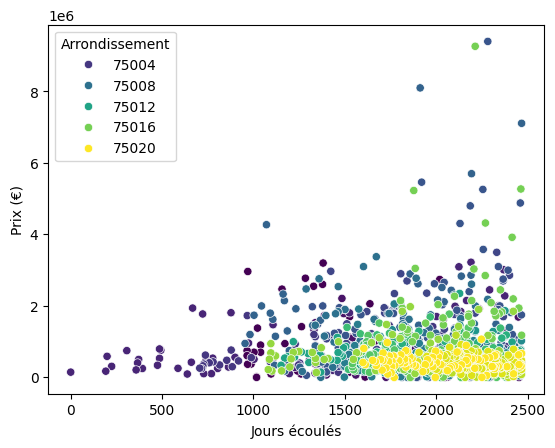

In [551]:
# Scatter plot
sns.scatterplot(x='Jours écoulés', y='Prix (€)', hue='Arrondissement', data=dfDate, palette='viridis')

In [553]:
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = train_test_split(dfDate, test_size=0.3, random_state=123)

# Ajuster le modèle de régression linéaire en utilisant une formule
formula = 'Q("Prix (€)") ~ Q("Pièce(s)") + Q("Surface (m2)") + Q("Jours écoulés") + Q("Arrondissement")'
model = smf.ols(formula=formula, data=train_data).fit(cov_type='HC3')

# Résumé du modèle
print(model.summary())

# Prédire les prix sur les données de test
predictions = model.predict(test_data)

# Évaluer les performances du modèle
rmse = np.sqrt(mean_squared_error(test_data['Prix (€)'], predictions))
mae = mean_absolute_error(test_data['Prix (€)'], predictions)
mape = mean_absolute_percentage_error(test_data['Prix (€)'], predictions)
r2 = r2_score(test_data['Prix (€)'], predictions)

                            OLS Regression Results                            
Dep. Variable:          Q("Prix (€)")   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     99.98
Date:                Thu, 23 May 2024   Prob (F-statistic):           4.46e-73
Time:                        03:36:09   Log-Likelihood:                -16601.
No. Observations:                1155   AIC:                         3.321e+04
Df Residuals:                    1150   BIC:                         3.324e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.17e+09   1

On constate un nombre de condition très large, et en faisant des tests ce n'est pas un problème de multicollinéarité mais plutôt de data scaling. Nous ne l'avons pas fait pour mieux visualiser les prix qui ont été prédit par le modèle

In [554]:
print(f'Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R²: {r2}')

# Après standardisation les données n'ont pas vraiment de sens, on va donc se concentrer sur le pourcentage d'erreur
print(f'Mean Absolute Percentage Error: {mape}% accuracy')

Mean Squared Error: 380490.19945142383
Mean Absolute Error: 187849.39037857708
R²: 0.7483681258075996
Mean Absolute Percentage Error: 13.94390680854607% accuracy


In [596]:
# Calculer les jours écoulés pour la date future (par exemple, 1er janvier 2050)
dateInput = '01/01/2050'

future_date = pd.to_datetime(dateInput, format='%d/%m/%Y')
days_elapsed_future = (future_date - reference_date).days

# Créer un nouveau DataFrame avec les valeurs modifiées pour les jours écoulés
test_data_future = test_data.copy()
test_data_future['Jours écoulés'] = days_elapsed_future

# Prédire les prix pour la date future
predictions_future = model.predict(test_data_future)

# Taux d'inflation annuel moyen (par exemple, 2.4%)
taux_inflation_annuel = 0.024

# Nombre d'années jusqu'en 2050
annee_reference = 2024  # Assurez-vous de définir l'année de référence correcte
annee_cible = 2050
nombre_annees = annee_cible - annee_reference

# Ajuster les valeurs pour l'inflation
valeurs_predites_future = [valeur * (1 + taux_inflation_annuel) ** nombre_annees for valeur in predictions_future]

In [595]:
# Exemple de valeurs réelles et prédites
valeurs_reelles = test_data['Prix (€)']

# Créer un DataFrame combinant les valeurs réelles et les valeurs prédites
df_results = pd.DataFrame({
    'Index': range(len(valeurs_reelles)),
    'Valeurs Réelles': valeurs_reelles,
    'Valeurs Prédites Futur': valeurs_predites_future
})

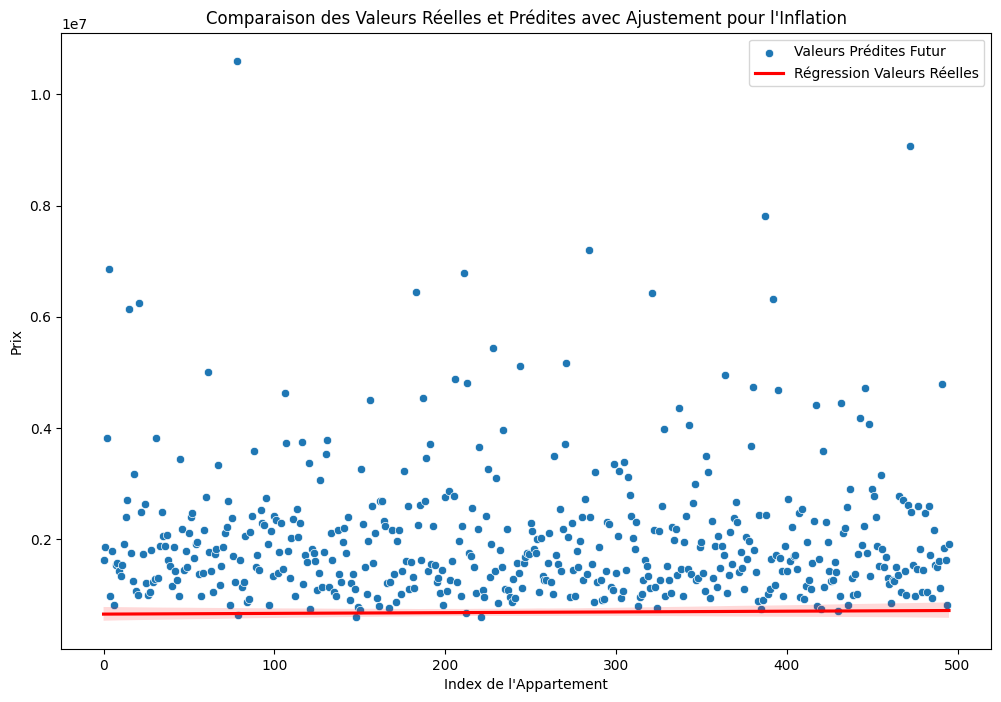

In [594]:
# Initialiser la figure
plt.figure(figsize=(12, 8))

# Plot des valeurs prédites pour le futur
sns.scatterplot(x='Index', y='Valeurs Prédites Futur', data=df_results, label='Valeurs Prédites Futur')

# Ajout d'une droite de régression pour les valeurs réelles
sns.regplot(x='Index', y='Valeurs Réelles', data=df_results, scatter=False, label='Régression Valeurs Réelles', color='red')

# Personnalisation du graphique
plt.xlabel('Index de l\'Appartement')
plt.ylabel('Prix')
plt.title('Comparaison des Valeurs Réelles et Prédites avec Ajustement pour l\'Inflation')
plt.legend()
plt.show()
